In [2]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from ruamel.yaml.scalarfloat import ScalarFloat

In [3]:
# creating paths
path = 'SavedModels/BIN-MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-13' # 2
config_name = 'config_001_unet.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_49999_unet.pt' #  model_299999_hollowMLEProb.pt

#config_name = 'config_001_r07.yaml' 
#model_name = 'model_84999_hollowr07.pt' 
config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [8]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'ElboTauL' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.loss.logit_type = 'reverse_prob'
cfg.sampler.num_corrector_steps = 3
cfg.sampler.corrector_entry_time = ScalarFloat(0.1)
cfg.sampler.num_steps = 500
cfg.sampler.is_ordinal = False

#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

number of parameters:  6138946
ema state dict function


In [9]:
n_samples = 36
samples, changes = sampler.sample(model, n_samples)
saved_samples = samples

500it [00:38, 12.87it/s]


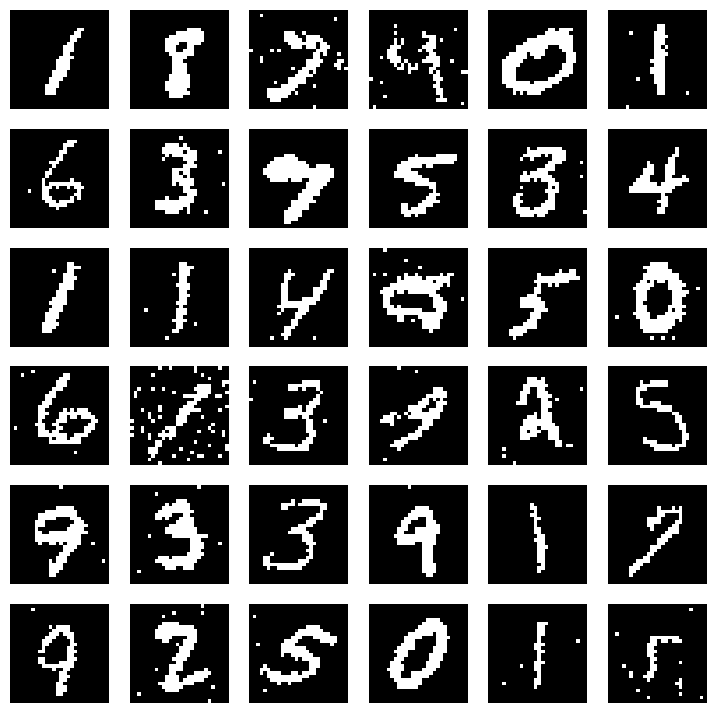

In [10]:
is_img = True

if is_img:
    samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)
    saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    fig = plt.figure(figsize=(9, 9)) 
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis("off")
        plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")
 
 
    plt.savefig(saving_train_path)
    plt.show()
    plt.close()
else:
    bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)
    print(inv_bm)
    samples = synthetic.bin2float(samples.astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)
 
    saving_plot_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    #aving_plot_path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/MNIST/'
    synthetic.plot_samples(samples, saving_plot_path, im_size=cfg.data.plot_size, im_fmt="png")

[0.3647959232330322, 0.06179138273000717, 0.045493196696043015, 0.035466268658638, 0.032135769724845886, 0.029372166842222214, 0.026927437633275986, 0.024978742003440857, 0.02278202958405018, 0.02083333395421505, 0.02008928544819355, 0.01938067004084587, 0.01665249466896057, 0.017679989337921143, 0.01707766391336918, 0.016439909115433693, 0.01714852638542652, 0.014668367803096771, 0.015306122601032257, 0.015518708154559135, 0.01353458035737276, 0.014172336086630821, 0.013959750533103943, 0.014491213485598564, 0.012329932302236557, 0.013747165910899639, 0.011231576092541218, 0.011125283315777779, 0.010345805436372757, 0.01116071455180645, 0.011833900585770607, 0.011231576092541218, 0.011018991470336914, 0.01105442177504301, 0.010381235741078854, 0.010700113140046597, 0.010381235741078854, 0.010806405916810036, 0.009885204024612904, 0.01116071455180645, 0.010452097281813622, 0.009849773719906807, 0.010983560234308243, 0.00956632662564516, 0.009601757861673832, 0.009849773719906807, 0.009

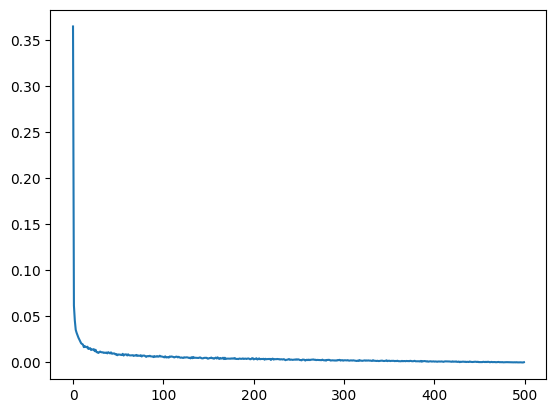

In [11]:
plt.plot(changes)
print(changes)
plt.show()